<a href="https://colab.research.google.com/github/RonTeichner/IRAS/blob/main/IDRAS_Proteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decoupling internal regulation from environmental influences**

## **A Kinetic Model of Regulatory Interactions**

Simulated data generated from a kinetic model that describes regulatory interactions in the production of two proteins that incorporating a feedback loop.
In the considered model, the total amount of two proteins $P$ and $S$, namely $P+S$, is controlled by $M$, the mRNA molecule that is produced through a process of constitutive transcription at a rate $K$ and degraded with first order kinetics at a rate $\gamma_M$. The model is under constant perturbations to the protein expression rate. The model is described by the differential equations  
$$
\begin{equation}
\label{eqn:kinetic model}
\begin{aligned}
    d{M}&= (K-F(P+S)-\gamma_M M)dt,\\
    d{P}&= (k_P M-\gamma_P P)dt + \eta_P dW_P,\\
    d{S}&= (k_S M-\gamma_S S)dt + \eta_S dW_S,
\end{aligned}
\end{equation}
$$

where the the mRNA and the two proteins $P,S$ are linked in a feedback loop. Both $P$ and $S$ are positively affected by $M$, with their steady-state values proportional to it. The concentration $M$ in turn, is negatively affected by the sum $P+S$, with the strength of this negative feedback given by the rate constant $F$.

Small changes in $S$ or $P$, modeled by the an increments of the Wiener processes $dW_P$ and $dW_S$, induce swift and sharp changes in the transcription of $M$ and maintain $P\!+\!S$ around a stable level. This is reflected in a high negative correlation between $S$ and $P$.  

To gain a better insight into the stability of the combination $P\!+\!S$, we consider the steady state of the system for a single constant parameter set. At steady state, the rate of change of all variables is zero, and $P\!+\!S$ is given by

$$
\begin{equation}
\begin{gathered}
\label{eqn:P_s_s+S_s_s}
    P_{\mathrm{ss}}+S_{\mathrm{ss}}=\cfrac{K}{F+\cfrac{\gamma_M\gamma_P\gamma_S}{k_P\gamma_S+k_S\gamma_P}} ~,
\end{gathered}
\end{equation}
$$

where $P_{\mathrm{ss}}$ and $S_{\mathrm{ss}}$ are the steady states of $P$ and $S$ respectively. If the strength of the negative feedback is large and satisfies $F\gg\cfrac{\gamma_M\gamma_P\gamma_S}{k_P\gamma_S+k_S\gamma_P}$, $P_{\mathrm{ss}}$+$S_{\mathrm{ss}}$ will approximately remain around the same setpoint despite the perturbations.
This indicates that $g(M,P,S)\!=\!S\!+\!P$ is a possible control objective of the system under these conditions.

We simulate with values $F=2000$, $K=300$, $k_S=k_P=150$, $\gamma_P=\gamma_S=70$ and $\gamma_M=80$.




In [ ]:
#!pip install torchsde
import torch
from torch import nn
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchsde
from scipy import interpolate

class SDE_1D(nn.Module):

    def __init__(self, dynamic_K):
        super().__init__()
        self.K = nn.Parameter(300*torch.ones(1), requires_grad=False)
        self.F = nn.Parameter(2000*torch.ones(1), requires_grad=False)
        self.gM = nn.Parameter(80*torch.ones(1), requires_grad=False)
        self.gP = nn.Parameter(70*torch.ones(1), requires_grad=False)
        self.gS = nn.Parameter(70*torch.ones(1), requires_grad=False)
        self.kP = nn.Parameter(150*torch.ones(1), requires_grad=False)
        self.kS = nn.Parameter(150*torch.ones(1), requires_grad=False)

        self.dynamic_K = dynamic_K

        self.K_f = nn.Parameter((1/0.2)*torch.ones(1), requires_grad=False)
        #self.K_phi = nn.Parameter(2*np.pi*torch.rand(1), requires_grad=False)
        self.K_amp = nn.Parameter(0.7*torch.ones(1), requires_grad=False)

        self.WienerGain = nn.Parameter(torch.tensor([0,0.5,0.5,0]), requires_grad=False)
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, x):
        # x [batch_size, state_size]
        #M,P,S,K = x[:,0], x[:,1], x[:,2], x[:,3]
        M,P,S, K_phi = x[:,0], x[:,1], x[:,2], x[:,3]

        dK_phi = torch.zeros_like(K_phi)

        K_omega = 2*np.pi*self.K_f

        if self.dynamic_K:
            K = self.K*(1 + self.K_amp*torch.cos(K_omega*t + K_phi))
        else:
            K = self.K

        dM = K - self.F*(P+S) - self.gM*M
        dP = self.kP*M - self.gP*P
        dS = self.kS*M - self.gS*S
        '''
        dK = self.K_amp*torch.cos(K_omega*t + self.K_phi)*torch.ones_like(K)

        if not self.dynamic_K:
            dK = dK*0
        '''
        #f_of_x = torch.cat((dM[:,None],dP[:,None],dS[:,None],dK[:,None]), dim=1)
        f_of_x = torch.cat((dM[:,None],dP[:,None],dS[:,None], dK_phi[:,None]), dim=1)
        return f_of_x

    def g(self, t, x):
        batch_size = x.shape[0]
        return self.WienerGain[None, :].repeat(batch_size,1)

def calcOrthogonalNoise(xs, sigma_eta, sde):
    dot_z = np.zeros_like(xs)
    for tIdx in range(xs.shape[0]):
        dot_z[tIdx] = sde.f(0, torch.tensor(xs[tIdx])).numpy()
    unitParallelVec = np.divide(dot_z, np.linalg.norm(dot_z, axis=2)[:,:,None].repeat(xs.shape[2],2))
    unitOrthogonalVec = np.zeros_like(unitParallelVec)
    for sIdx in range(xs.shape[1]):
        for tIdx in range(xs.shape[0]):
            fIdx = np.random.randint(xs.shape[2])
            noise = np.random.randn(xs.shape[2])
            dz = unitParallelVec[tIdx,sIdx]
            noise[fIdx] = -np.dot(np.concatenate((noise[:fIdx], noise[fIdx+1:])), np.concatenate((dz[:fIdx], dz[fIdx+1:])))/dz[fIdx]
            unitNoise = noise/np.linalg.norm(noise)
            unitOrthogonalVec[tIdx, sIdx] = np.sqrt(xs.shape[2]*(sigma_eta**2))*unitNoise
    return unitOrthogonalVec



Let us view 3 Protein processes,

In [ ]:
def plot(ts, samples, xlabel, ylabel, title=''):
    nT, nSystems, nStates = samples.shape[0], samples.shape[1], samples.shape[2]
    plt.figure()#figsize=(20/1.5,5/1.5))
    strings = ['M', 'P', 'S', 'K_phi']
    for s in range(nSystems):
        systemSample = samples[:,s]
        #plt.subplot(nSystems,2,2*s+1)
        plt.subplot(nSystems,1,s+1)
        plt.plot(ts, systemSample[:len(ts),1:3].mean(axis=1), 'k', linewidth = 2.0, label=r'$\frac{1}{2}(P+S)=$'+f'{str(round(systemSample[:len(ts),1:3].mean(axis=1).mean(), 4))}'+r'$\pm$'+f'{str(round(systemSample[:len(ts),1:3].mean(axis=1).std(), 4))}')
        for i in range(1,3):
            plt.plot(ts, systemSample[:len(ts),i], linewidth = 1.0, label=strings[i])
        plt.title(title + f'system s={s}')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        #plt.grid()
        plt.tight_layout()
        '''
        plt.subplot(nSystems,2,2*s+2)
        i=3
        plt.plot(ts, systemSample[:len(ts),i], linewidth = 1.0, label=strings[i])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        #plt.grid()
        plt.tight_layout()
        '''
        plt.show()


## Evaluating IRAS algorithm

We train the combination player on inputs originated from the observations and inputs generated by the shuffle player. The combination player's objective is to minimize the CR. It is trained using the SGD optimizer.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 28 17:31:44 2023

@author: ron.teichner
"""

import torch
import torch.nn as nn
import time

class Combination_ANN(nn.Module):
  def __init__(self, mu, Sigma_minus_half, features2ShuffleTogether, playerPerPatient, learnThrProcess, dt):
        super(Combination_ANN, self).__init__()
        self.nAncestors = 10
        self.learnThrProcess = learnThrProcess
        self.detachMode = True
        self.dt = dt
        self.inputDim = Sigma_minus_half.shape[0]
        self.shuffleFactor = 100
        self.Sigma_minus_half = nn.parameter.Parameter(torch.tensor(Sigma_minus_half, dtype=torch.float), requires_grad=False)
        self.mu = nn.parameter.Parameter(torch.tensor(mu, dtype=torch.float), requires_grad=False)
        self.features2ShuffleTogetherLists = features2ShuffleTogether
        self.playerPerPatient = playerPerPatient
        self.shuffleCompleteDaughters = learnThrProcess
        self.dimLatent = 2
        self.simpleNets = True

        if self.learnThrProcess:

            #self.timeUpdate = nn.Sequential(nn.Linear(1, 1))
            if self.simpleNets:
                self.encoder = nn.Sequential(nn.Linear(self.nAncestors, self.dimLatent),
                                             nn.Tanh())

                self.decoder = nn.Sequential(nn.Linear(self.dimLatent, 1),
                                             nn.Sigmoid())

                self.timeUpdate = nn.Sequential(nn.Linear(self.dimLatent, self.dimLatent),
                                                nn.Tanh())
            else:
                self.encoder = nn.Sequential(nn.Linear(self.nAncestors, 32),
                                                  nn.LeakyReLU(),
                                                  #nn.Linear(64, 32),
                                                  #nn.ReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, self.dimLatent),
                                                  nn.Tanh())
                self.decoder = nn.Sequential(nn.Linear(self.dimLatent, 32),
                                                  nn.LeakyReLU(),
                                                  #nn.Linear(64, 32),
                                                  #nn.ReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, 1),
                                                  nn.Sigmoid())
                self.timeUpdate = nn.Sequential(nn.Linear(self.dimLatent, 32),
                                                  nn.LeakyReLU(),
                                                  #nn.Linear(64, 32),
                                                  #nn.ReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, self.dimLatent),
                                                  nn.Tanh())


            '''
            self.timeUpdate = nn.Sequential(nn.Linear(self.nAncestors+2, 32),
                                                      nn.LeakyReLU(),
                                                      #nn.Linear(64, 32),
                                                      #nn.ReLU(),
                                                      nn.Linear(32, 16),
                                                      nn.LeakyReLU(),
                                                      nn.Linear(16, 1),
                                                      nn.Sigmoid())
            '''






        self.sequence = nn.Sequential(nn.Linear(self.inputDim, 32),
                                                  nn.LeakyReLU(),
                                                  #nn.Linear(64, 32),
                                                  #nn.ReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, 1),
                                                  nn.Sigmoid())



  def shuffle(self, observations):
    naiveShuffledObservations = torch.zeros_like(observations)
    if self.shuffleCompleteDaughters:
        if not self.playerPerPatient:
            permuteSystemIdx = torch.randperm(observations.shape[0])#torch.randint_like(input=observations, low=0, high=observations.shape[0], dtype=torch.int64)
            permuteTimeIdx = torch.randperm(observations.shape[1])#torch.randint_like(input=observations, low=0, high=observations.shape[1], dtype=torch.int64)

            systemPermutedObservations = observations[permuteSystemIdx]#torch.gather(input=observations, dim=0, index=permuteSystemIdx)
            timeSystemPermutedObservations = systemPermutedObservations[:,permuteTimeIdx]#torch.gather(input=systemPermutedObservations, dim=1, index=permuteTimeIdx)
            naiveShuffledObservations[:,:] = timeSystemPermutedObservations[:,:]
        else:
            for s in range(observations.shape[0]):
                permuteIdx = torch.randperm(observations.shape[1])
                for f in range(observations.shape[2]):
                    naiveShuffledObservations[s,:,f] = observations[s,permuteIdx,f]
    else:
        if not self.playerPerPatient:
          for features2ShuffleTogether in self.features2ShuffleTogetherLists:
            permuteSystemIdx = torch.randperm(observations.shape[0])#torch.randint_like(input=observations, low=0, high=observations.shape[0], dtype=torch.int64)
            permuteTimeIdx = torch.randperm(observations.shape[1])#torch.randint_like(input=observations, low=0, high=observations.shape[1], dtype=torch.int64)

            systemPermutedObservations = observations[permuteSystemIdx]#torch.gather(input=observations, dim=0, index=permuteSystemIdx)
            timeSystemPermutedObservations = systemPermutedObservations[:,permuteTimeIdx]#torch.gather(input=systemPermutedObservations, dim=1, index=permuteTimeIdx)
            naiveShuffledObservations[:,:,features2ShuffleTogether] = timeSystemPermutedObservations[:,:,features2ShuffleTogether]
        else:
          enableUniformSampling = False
          if enableUniformSampling:
              minf, maxf = observations.min(), observations.max()
              naiveShuffledObservations = minf + (maxf-minf)*torch.rand_like(naiveShuffledObservations)
          else:
              for s in range(observations.shape[0]):
                for features2ShuffleTogether in self.features2ShuffleTogetherLists:
                  permuteIdx = torch.randperm(observations.shape[1])
                  for f in features2ShuffleTogether:
                    naiveShuffledObservations[s,:,f] = observations[s,permuteIdx,f]



    return naiveShuffledObservations

  def multipleShuffles(self, observations):
    naiveShuffledObservations = torch.zeros((observations.shape[0], int(observations.shape[1]*self.shuffleFactor), observations.shape[2]), dtype=torch.float, device=observations.device)
    for sf in range(self.shuffleFactor):
      naiveShuffledObservations[:,sf*observations.shape[1]:(sf+1)*observations.shape[1]] = self.shuffle(observations)
    return naiveShuffledObservations

  def normalizeObservations(self, observations):
    nSystem = observations.shape[0]
    nTime = observations.shape[1]
    means = self.mu[None, None, :, :].expand(nSystem, nTime, -1, -1)
    Sigma_minus_half = self.Sigma_minus_half[None, None, :, :].expand(nSystem, nTime, -1, -1)
    tilde_z = observations[:, :, :, None]
    nan_indices = tilde_z.isnan()
    tilde_z[nan_indices] = torch.zeros_like(tilde_z[nan_indices])
    normalized_tilde_z = torch.matmul(Sigma_minus_half, tilde_z - means)
    normalized_tilde_z[nan_indices] = torch.nan
    normalized_tilde_z = normalized_tilde_z[:,:,:, 0]

    return normalized_tilde_z

  def timeUpdateError(self, combination_daughter, combination_ancestors, timeDiff):

    #print(f'shape of timeDiff {timeDiff.shape}')
    predicted_combination_daughter = torch.zeros_like(combination_daughter, device=combination_daughter.device)
    tVec = torch.arange(0, 1.2*timeDiff.max(), self.dt, device=combination_daughter.device)
    nIters = int(torch.ceil(1.1*timeDiff.max()/self.dt))

    if self.detachMode:
        combination_ancestors = combination_ancestors.detach()

    #predicted_combination_daughter = combination_mother + 2*(self.timeUpdate(combination_mother)-0.5)
    currentComb = combination_ancestors[:,:,-1].unsqueeze(-1)
    currentLatentState_kMinus1 = self.encoder(combination_ancestors)
    reconstructionError = currentComb.detach() - self.decoder(self.encoder(combination_ancestors.detach()))
    for t in range(1, nIters):
        #print(f'{t} out of {nIters}')
        #display.clear_output(wait=True)
        time = tVec[t]
        updateIndices = torch.abs(timeDiff-time) <= self.dt/2
        #print(f'shape of updateIndices {updateIndices.shape}')

        timeExpanded = time*torch.ones((combination_ancestors.shape[0], combination_ancestors.shape[1], 1), device=time.device)

        dc = self.timeUpdate(currentLatentState_kMinus1)#-0.5
        #print(f'shape of combination_ancestors {combination_ancestors.shape}')
        exactUpdate = dc - dc/self.dt*(time-timeDiff.expand(-1,-1,self.dimLatent))
        #print(f'shape of exactUpdate {exactUpdate.shape}')
        predicted_combination_daughter[updateIndices] = self.decoder(currentLatentState_kMinus1 + exactUpdate)[updateIndices]
        currentLatentState_kMinus1 = currentLatentState_kMinus1 + dc

    if self.detachMode:
        combination_daughter_error = combination_daughter.detach() - predicted_combination_daughter
    else:
        combination_daughter_error = combination_daughter - predicted_combination_daughter

    '''
    #print(f'shape of timeDiff {timeDiff.shape}')
    reconstructionError = None
    predicted_combination_daughter = torch.zeros_like(combination_daughter)
    tVec = torch.arange(0, 1.2*timeDiff.max(), self.dt, device=combination_daughter.device)
    nIters = int(1.1*timeDiff.max()/self.dt)

    if self.detachMode:
        combination_ancestors = combination_ancestors.detach()

    enable_dcAcc = False
    currentVal = combination_ancestors[:,:,-1].unsqueeze(-1)
    if enable_dcAcc:


        for t in range(nIters):
            #print(f'{t} out of {nIters}')
            #display.clear_output(wait=True)
            time = tVec[t]
            updateIndices = torch.abs(timeDiff-time) <= self.dt/2
            #print(f'shape of updateIndices {updateIndices.shape}')

            timeExpanded = time*torch.ones((combination_ancestors.shape[0], combination_ancestors.shape[1], 1), device=time.device)

            dc = self.timeUpdate(torch.cat((combination_ancestors, currentVal, timeExpanded),dim=2))-0.5
            #print(f'shape of combination_ancestors {combination_ancestors.shape}')
            exactUpdate = dc - dc/self.dt*(time-timeDiff)
            #print(f'shape of exactUpdate {exactUpdate.shape}')
            predicted_combination_daughter[updateIndices] = currentVal[updateIndices] + exactUpdate[updateIndices]
            currentVal = currentVal + dc
    else:
        time = tVec[0]
        timeExpanded = time*torch.ones((combination_ancestors.shape[0], combination_ancestors.shape[1], 1), device=time.device)
        dc = 2*(self.timeUpdate(torch.cat((combination_ancestors, currentVal, timeExpanded),dim=2))-0.5)
        predicted_combination_daughter = currentVal + dc

    if self.detachMode:
        combination_daughter_error = combination_daughter.detach() - predicted_combination_daughter
    else:
        combination_daughter_error = combination_daughter - predicted_combination_daughter
    '''
    return combination_daughter_error, predicted_combination_daughter, reconstructionError

  def getCombinationsAncestors(self, combination):
    combination_ancestors = torch.zeros((combination.shape[0], combination.shape[1]-self.nAncestors, self.nAncestors), device=combination.device)
    for daughterIdx in range(combination_ancestors.shape[1]):
        combination_ancestors[:,daughterIdx] = combination[:,daughterIdx:daughterIdx+self.nAncestors,0]
    return combination_ancestors

  def forward(self, observations, observationsTvec):
    combination_daughter_error, combination_shuffle_daughter_error = None, None
    combination_daughter, predicted_combination_daughter = None, None
    reconstructionError = None
    #print(f'shape of observationsTvec {observationsTvec.shape}')
    combination = self.sequence(self.normalizeObservations(observations))
    if self.learnThrProcess:
        observations_daughter = observations[:,self.nAncestors:]
        combination_daughter = combination[:,self.nAncestors:]
        combination_ancestors = self.getCombinationsAncestors(combination)
        time_daughters = observationsTvec[:,self.nAncestors:]
        time_mothers = observationsTvec[:,self.nAncestors-1:-1]
        timeDiff = time_daughters - time_mothers
        combination_daughter_error, predicted_combination_daughter, reconstructionError = self.timeUpdateError(combination_daughter, combination_ancestors, timeDiff)
        #print(f'T daughter mean, std = {observations_daughter[:,:,2].detach().cpu().numpy().mean()}, {observations_daughter[:,:,2].detach().cpu().numpy().std()}')
        #print(f'sys0: T daughter mean, std = {observations_daughter[0,:,2].detach().cpu().numpy().mean()}, {observations_daughter[0,:,2].detach().cpu().numpy().std()}')
        #print(f'error daughter mean, std = {combination_daughter_error.detach().cpu().numpy().mean()}, {combination_daughter_error.detach().cpu().numpy().std()}')
        #print(f'sys0: error daughter mean, std = {combination_daughter_error[0].detach().cpu().numpy().mean()}, {combination_daughter_error[0].detach().cpu().numpy().std()}')
        #print('')
    # shuffle:
    naiveShuffledObservations = self.multipleShuffles(observations)
    #print(f'naiveShuffledObservations T mean, std = {naiveShuffledObservations[:,:,2].detach().cpu().numpy().mean()}, {naiveShuffledObservations[:,:,2].detach().cpu().numpy().std()}')
    #print(f'sys0: naiveShuffledObservations T mean, std = {naiveShuffledObservations[0,:,2].detach().cpu().numpy().mean()}, {naiveShuffledObservations[0,:,2].detach().cpu().numpy().std()}')
    #print('')
    combinationOnNaiveShuffle = self.sequence(self.normalizeObservations(naiveShuffledObservations))

    if self.learnThrProcess:
        fakeTimeDiff = torch.cat((timeDiff[:,:self.nAncestors], timeDiff), dim=1)
        fake_combination_ancestors = torch.cat((combination_ancestors[:,:self.nAncestors], combination_ancestors), dim=1)
        combination_shuffle_daughter_error, _, _ = self.timeUpdateError(combinationOnNaiveShuffle, fake_combination_ancestors.repeat(1,self.shuffleFactor,1), fakeTimeDiff.repeat(1,self.shuffleFactor,1))
        #print(f'T shuffled daughter mean, std = {observations_shuffled_daughter[:,:,2].detach().cpu().numpy().mean()}, {observations_shuffled_daughter[:,:,2].detach().cpu().numpy().std()}')
        #print(f'sys0: shuffled T daughter mean, std = {observations_shuffled_daughter[0,:,2].detach().cpu().numpy().mean()}, {observations_shuffled_daughter[0,:,2].detach().cpu().numpy().std()}')
        #print(f'shuffled error daughter mean, std = {combination_shuffle_daughter_error.detach().cpu().numpy().mean()}, {combination_shuffle_daughter_error.detach().cpu().numpy().std()}')
        #print(f'sys0: shuffled error daughter mean, std = {combination_shuffle_daughter_error[0].detach().cpu().numpy().mean()}, {combination_shuffle_daughter_error[0].detach().cpu().numpy().std()}')

    return combination, combinationOnNaiveShuffle, naiveShuffledObservations, combination_daughter_error, combination_shuffle_daughter_error, (combination_daughter, predicted_combination_daughter), reconstructionError

def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to")

def shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient):

  device = combination.device
  combination, combinationOnNaiveShuffle = combination.detach(), combinationOnNaiveShuffle.detach()
  nBins = 250
  shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
  baseLength = combination.shape[1]
  nSystems = combination.shape[0]

  if not(playerPerPatient):
    comb_data_flatten, comb_shuffle_flatten = torch.zeros((0), dtype=torch.float, device=combination.device), torch.zeros((0), dtype=torch.float, device=combination.device)

    for p in range(nSystems):
        comb_data_flatten_singlePatient = combination[p, :, 0]
        comb_data_flatten = torch.cat((comb_data_flatten, comb_data_flatten_singlePatient))

        comb_shuffle_flatten_singlePatient = torch.zeros((0), dtype=torch.float, device=combination.device)
        for s in range(shuffleFactor):
            start = s*baseLength
            stop = start + baseLength
            comb_shuffle_flatten_singleShuffle = combinationOnNaiveShuffle[p, start:stop, 0]
            comb_shuffle_flatten_singlePatient = torch.cat((comb_shuffle_flatten_singlePatient, comb_shuffle_flatten_singleShuffle))
        comb_shuffle_flatten = torch.cat((comb_shuffle_flatten, comb_shuffle_flatten_singlePatient))


    min_range = comb_data_flatten.min()
    max_range = comb_data_flatten.max()

    bins = torch.linspace(min_range, max_range, nBins, device='cpu')
    prob_data = torch.histogram(comb_data_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]
    prob_shuffle = torch.histogram(comb_shuffle_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]

    binsDict = {'bins': bins, 'minVal': min_range, 'maxVal': max_range}
  else:
    binsDict, prob_data, prob_shuffle = list(), list(), list()
    for p in range(nSystems):
      comb_data_flatten_singleSystem = combination[p, :, 0]

      systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combination.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combination.device)[None, :].repeat(baseLength, 1)).flatten()
      comb_shuffle_flatten_singleSystem = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices)

      min_range = comb_data_flatten_singleSystem.min()
      max_range = comb_data_flatten_singleSystem.max()

      bins = torch.linspace(min_range, max_range, nBins, device='cpu')
      prob_data_patient = torch.histogram(comb_data_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]
      prob_shuffle_patient = torch.histogram(comb_shuffle_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]

      if prob_data_patient.isnan().any():
        prob_data.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
      else:
        prob_data.append(prob_data_patient)

      if prob_shuffle_patient.isnan().any():
        prob_shuffle.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
      else:
        prob_shuffle.append(prob_shuffle_patient)

      binsDict.append({'bins': bins, 'minVal': min_range, 'maxVal': max_range})


  prob_data, prob_shuffle, binsDict = move_to(prob_data, device), move_to(prob_shuffle, device), move_to(binsDict, device)
  combination, combinationOnNaiveShuffle = combination.to(device), combinationOnNaiveShuffle.to(device)
  combinationOnNaiveShuffle_selectionProb = torch.zeros_like(combinationOnNaiveShuffle)

  if not(playerPerPatient):
    bins, minVal, maxVal = binsDict['bins'], binsDict['minVal'], binsDict['maxVal']
    prob_select = torch.zeros_like(prob_data)
    posProbInx = prob_shuffle > 0
    #if not posProbInx.any():
    #    print(f'prob_shuffle is strickly zero')
    #else:
    #    print(f'prob_shuffle has {posProbInx.sum()} > 0 bins')
    prob_select[posProbInx] = prob_data[posProbInx]/prob_shuffle[posProbInx]
    prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()

    validIndices = torch.zeros_like(combinationOnNaiveShuffle, device=combinationOnNaiveShuffle.device).bool()

    for p in range(nSystems):
        lengthOfCurrentSeries = baseLength
        for s in range(shuffleFactor):
            start = s*baseLength
            stop = start + lengthOfCurrentSeries
            validIndices[p, start:stop] = True

    validIndices[combinationOnNaiveShuffle < minVal] = False
    validIndices[combinationOnNaiveShuffle > maxVal] = False

    bin_belong = torch.zeros_like(combinationOnNaiveShuffle, dtype=torch.long, device=combinationOnNaiveShuffle.device)
    for b in range(bins.shape[0]-1):
        bin_belong[combinationOnNaiveShuffle >= bins[b]] = b

    combinationOnNaiveShuffle_selectionProb = prob_select[bin_belong]
    combinationOnNaiveShuffle_selectionProb[torch.logical_not(validIndices)] = 0
  else:
    for p in range(nSystems):
      bins, minVal, maxVal = binsDict[p]['bins'], binsDict[p]['minVal'], binsDict[p]['maxVal']

      prob_select = torch.zeros_like(prob_data[p])
      posProbInx = prob_shuffle[p] > 0
      prob_select[posProbInx] = prob_data[p][posProbInx]/prob_shuffle[p][posProbInx]
      prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()

      validIndices = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], device=combinationOnNaiveShuffle.device).bool()

      for s in range(shuffleFactor):
        start = s*baseLength
        stop = start + baseLength
        validIndices[0, start:stop] = True

      validIndices[combinationOnNaiveShuffle[p:p+1] < minVal] = False
      validIndices[combinationOnNaiveShuffle[p:p+1] > maxVal] = False

      bin_belong = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], dtype=torch.long, device=combinationOnNaiveShuffle.device)

      for b in range(bins.shape[0]-1):
        bin_belong[combinationOnNaiveShuffle[p:p+1] >= bins[b]] = b

      combinationOnNaiveShuffle_selectionProb[p] = prob_select[bin_belong][0]
      combinationOnNaiveShuffle_selectionProb[p][torch.logical_not(validIndices)[0]] = 0

  return combinationOnNaiveShuffle_selectionProb

def CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb, playerPerPatient):
    #playerPerPatient = False
    shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
    baseLength = combination.shape[1]
    nSystems = combination.shape[0]
    totalSeriesLengths  = int(nSystems*baseLength)
    totalShuffleSeriesLengths  = totalSeriesLengths*shuffleFactor

    combinationStds, combinationOnShuffledStds, combinationOnNaiveShuffledStds = torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device)
    selectedShuffleCombinations = torch.zeros((0), dtype=torch.float, device=combination.device)

    combinationIndices = torch.zeros((totalSeriesLengths), dtype=torch.long, device=combination.device)
    systemCombinationsStartIdx = 0
    for p in range(nSystems):
        combinationIndices[systemCombinationsStartIdx:systemCombinationsStartIdx+baseLength] = torch.arange(baseLength) + baseLength*p
        systemCombinationsStartIdx += baseLength
    systemCombinations = torch.gather(combination.flatten(), 0, combinationIndices)
    naiveShuffleCombinations = torch.zeros((totalShuffleSeriesLengths), dtype=torch.float, device=systemCombinations.device)
    systemCombinationsStartIdx = 0

    totalSelected = 0
    for p in range(nSystems):
        systemCombination = combination[p:p + 1]
        systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[None, :].repeat(baseLength, 1)).flatten()
        systemShuffledCombinationProb = torch.gather(combinationOnNaiveShuffle_selectionProb[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
        systemShuffledCombination = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
        combinationStds[p] = systemCombination.std()
        naiveShuffleCombinations[systemCombinationsStartIdx:systemCombinationsStartIdx+systemShuffledCombination.shape[1]] = systemShuffledCombination[0, :, 0]
        systemCombinationsStartIdx += systemShuffledCombination.shape[1]

        selection = torch.rand_like(systemShuffledCombinationProb) < systemShuffledCombinationProb
        totalSelected += selection.sum().item()
        selectedShuffleCombinationsSingleSystem = systemShuffledCombination[selection]
        selectedShuffleCombinations = torch.cat((selectedShuffleCombinations, selectedShuffleCombinationsSingleSystem))

        combinationOnNaiveShuffledStds[p] = systemShuffledCombination.std()
        if selection.sum() < 5:
          print(f'no selections patient no. {p}')
          combinationOnShuffledStds[p] = 0
        else:
          combinationOnShuffledStds[p] = selectedShuffleCombinationsSingleSystem.std()

    if playerPerPatient:
        validPatientIndices = combinationOnShuffledStds > 0
        if validPatientIndices.any():
            stdRatios = torch.divide(combinationStds[validPatientIndices], combinationOnShuffledStds[validPatientIndices])
            CR = stdRatios.mean()

            stdRatios_naiveShuffle = torch.divide(combinationStds[validPatientIndices], combinationOnNaiveShuffledStds[validPatientIndices])
            CR_zeta1 = stdRatios_naiveShuffle.mean()
    else:
        CR = torch.divide(systemCombinations.std(), selectedShuffleCombinations.std())
        CR_zeta1 = torch.divide(systemCombinations.std(), naiveShuffleCombinations.std())
    return CR, CR_zeta1, selectedShuffleCombinations.shape[0]

def printShufflePlayerAndCombination(Data_init, Data_shuffle_init, std_data, mean_data, epoch, corrs, titleStr, onlyDist=False):

  init_mean= Data_init['comb'].mean()
  init_std = Data_init['comb'].std()
  Data_init.loc[:,'comb'] = (Data_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data
  Data_init.loc[:,'combGT'] = (Data_init['combGT'].to_numpy() - mean_data)/std_data*std_data + mean_data
  Data_shuffle_init.loc[:,'comb'] = (Data_shuffle_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data



  plt.figure(figsize=(24/1.5,9/1.5/2))
  plt.suptitle(titleStr + f': Epoch {epoch}: ' + f'Pearson correlations (sizer, adder, timer) = ({str(round(np.abs(corrs[0]), 2))}, {str(round(np.abs(corrs[1]), 2))}, {str(round(np.abs(corrs[2]), 2))})')
  nBins = 16
  dataBoundaryColor = 'white'


  plt.subplot(1,3,1)
  plt.title('PDF')
  authenticCombValues = Data_init['comb']
  naiveCombValues = Data_shuffle_init['comb']
  selectionProb = Data_shuffle_init['ProbAssignedByPlayer']
  # create selected comb values:
  selectedCombValues = naiveCombValues[selectionProb > np.random.rand(naiveCombValues.shape[0])]
  min_range = authenticCombValues.min()
  max_range = authenticCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(authenticCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(Z))$')

  min_range = selectedCombValues.min()
  max_range = selectedCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(selectedCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dashed', label=r'$P(g(\tilde{Z}))$')

  min_range = naiveCombValues.min()
  max_range = naiveCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(naiveCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dotted', label=r'$P(g(\bar{Z}))$')

  #plt.axvline(authenticCombValues.min(), color='b', linewidth=1)
  #plt.axvline(authenticCombValues.max(), color='b', linewidth=1)#, label='D-b')
  #plt.ylabel(r'Iteration $0$',fontsize = 14)
  plt.xlabel('r',fontsize = 14)
  plt.legend(fontsize = 10, loc='upper left')
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 10)
  #plt.xlim([0,4])
  #plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
  plt.tight_layout()

  if not onlyDist:
      plt.subplot(1,3,2)
      plt.tricontourf(Data_shuffle_init['xb'],Data_shuffle_init['T'],Data_shuffle_init['ProbAssignedByPlayer'],20,cmap='plasma')
      plt.xlabel(r'$x_b$',fontsize=14)
      plt.ylabel(r'$T$',fontsize=14)
      plt.title("Probability of selection",fontsize=14)
      cbar=plt.colorbar()
      #cbar.ax.set_ylabel("Probability of selection",fontsize=14)
      v=np.arange(np.min(Data_shuffle_init['xb']),np.max(Data_shuffle_init['xb']),0.05)
      #plt.legend(ncol=2,fontsize=10)
      plt.yticks(fontsize = 14)
      plt.xticks(fontsize = 10)
      #plt.ylim([1.2,9])
      plt.tight_layout()

      plt.subplot(1,3,3)
      #vmin, vmax = -0.75, 4.5
      plt.title(r"$g(x_b,T)$",fontsize=14)
      plt.xlabel(r'$x_b$',fontsize=14)
      #d=reg.predict(Data_shuffle_init['comb'].array.reshape(-1,1))
      d=Data_shuffle_init['comb'].array.reshape(-1,1)
      plt.tricontourf(Data_shuffle_init['xb'],Data_shuffle_init['T'],d.reshape(-1),20)#,vmin=vmin,vmax=vmax)
      #plt.ylabel(r'$P_2$',fontsize=14)
      #cbar=plt.colorbar()
      #cbar.ax.set_ylabel(r"Two player $g(P_1,P_2)$",fontsize=14)
      #plt.legend(ncol=2,fontsize=10)
      plt.yticks(fontsize = 14)
      plt.xticks(fontsize = 10)
      plt.tight_layout()
      #plt.ylim([1.2,9])
      '''
      plt.subplot(4,1,4)
      a = Data_init['comb'][:100]
      b = Data_init['combGT'][:100]
      a = (a-a.mean())/a.std()
      b = (b-b.mean())/b.std()
      if corr < 0:
        a = -a
      plt.plot(a, label=r'$g(x_b,T)$')
      plt.plot(b, label=r'$x_d$')
      plt.legend(fontsize=14)
      plt.xlabel(f'Pearson correlation = {str(round(np.abs(corr), 2))}', fontsize=14)
      plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
      '''
  display.display(plt.gcf())
  display.clear_output(wait=True)

  plt.show()

import torch.optim as optim
from IPython import display
import pandas as pd
%matplotlib inline

def train(epoch, switch2dtIRASepoch, combinationPlayer, optimizer, scheduler, observations_torch, observations_tVec_torch, hypotheses_regulations, learnThrProcess, playerPerPatient, optimizerStr, trainFlag, debugPreShuffle=False):
    meanPredictionCorr = None
    dtIRAS_mode = epoch >= switch2dtIRASepoch
    combinationPlayer.detachMode = not(dtIRAS_mode)

    if trainFlag:
        combinationPlayer.train()
        optimizer.zero_grad()
    else:
        combinationPlayer.eval()

    # combination player:
    singleBatch = observations_torch
    singleBatchTvec = observations_tVec_torch
    combination, combinationOnNaiveShuffle, naiveShuffledObservations, combination_daughter_error, combination_shuffle_daughter_error, combinationDaughterTuple, reconstructionError = combinationPlayer(singleBatch, singleBatchTvec)
    combination_daughter_error_preSigmoid = combination_daughter_error
    # shuffle player:
    if learnThrProcess:
        if dtIRAS_mode:
            combination_daughter_error = torch.sigmoid(combination_daughter_error)
            combination_shuffle_daughter_error = torch.sigmoid(combination_shuffle_daughter_error)

            combinationOnNaiveShuffle_selectionProb = shufflePlayer(combination_daughter_error, combination_shuffle_daughter_error, playerPerPatient=False) # all errors are with set-point 0
            # Coefficient of Regulation:
            CR, CR_zeta1, nSelected = CoefficientOfRegulation(combination_daughter_error, combination_shuffle_daughter_error, combinationOnNaiveShuffle_selectionProb, playerPerPatient=False) # all errors are with set-point 0

            combinationOnNaiveShuffle_selectionProb_native = shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient)

        daughterPrediction_VAR = combination_daughter_error.var()
        predictionCorrelationsList = list()
        nPredictionErrorSqrtEnergy = np.zeros(combinationDaughterTuple[0].shape[0])
        for sysIdx in range(combinationDaughterTuple[0].shape[0]):
            #combinationDaughterTuple[0] - combinationDaughter
            #combinationDaughterTuple[1] - predicted combinationDaughter
            daughterComb = combinationDaughterTuple[0][sysIdx].detach().cpu().numpy().flatten()
            daughterCombPrediction = combinationDaughterTuple[1][sysIdx].detach().cpu().numpy().flatten()
            predictionCorrelationsList.append(pd.Series(daughterComb).corr(pd.Series(daughterCombPrediction)))
            daughterComb = (daughterComb - daughterComb.mean())/daughterComb.std()
            daughterCombPrediction = (daughterCombPrediction - daughterCombPrediction.mean())/daughterCombPrediction.std()
            if predictionCorrelationsList[sysIdx] < 0:
                daughterCombPrediction = -daughterCombPrediction
            nPredictionErrorSqrtEnergy[sysIdx] = (daughterCombPrediction-daughterComb).std()
        meanPredictionErrorEnergy_db = 20*np.log10(nPredictionErrorSqrtEnergy.mean())
        predictionErrorEnergyStr = f'Pred_error = {str(round(meanPredictionErrorEnergy_db, 2))} db'
        daughterPrediction_CR = combination_daughter_error.std()/combination_shuffle_daughter_error.std()
    else:
        combinationOnNaiveShuffle_selectionProb = shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient)
        # Coefficient of Regulation:
        CR, CR_zeta1, nSelected = CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb, playerPerPatient)

    if False:#learnThrProcess:
        plt.figure()
        plt.scatter(x=combinationDaughterTuple[0][sysIdx].detach().cpu().numpy()[:,0], y=combinationDaughterTuple[1][sysIdx].detach().cpu().numpy()[:,0])
        plt.show()

    # update the combination player as to minimize the CR:
    if trainFlag:
        if debugPreShuffle:
            daughterPrediction_VAR/combinationDaughterTuple[0].var().backward()
            if epoch == 0:
                print('daughterPrediction_VAR optimization')
        else:
            if learnThrProcess:
                if dtIRAS_mode:
                    reconstructionErrorLoss = torch.pow(reconstructionError, 2).mean()
                    #(CR + reconstructionErrorLoss).backward()
                    CR.backward()
            else:
                CR.backward()
        optimizer.step()  # parameter update
        scheduler.step()

    if trainFlag:
        trainStr = 'train. '
    else:
        trainStr = 'validation. '

    if learnThrProcess:
        plt.figure(figsize=(24/1.5,9/1.5/2))
        plt.subplot(1,2,1)
        ded = combination_daughter_error.detach().cpu().numpy().flatten()
        ned = combination_shuffle_daughter_error.detach().cpu().numpy().flatten()
        pced = combinationOnNaiveShuffle_selectionProb.detach().cpu().numpy().flatten()
        sed = ned[pced >= np.random.rand(pced.shape[0])]
        plt.title(trainStr + f': Epoch {epoch}: Prediction error')
        plt.hist(ded, bins=25,color='blue', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(Z))$')
        plt.hist(ned, bins=25, linestyle='dashed',color='green', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\tilde{Z}))$')
        plt.hist(sed, bins=25,linestyle='dashed',color='orange', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\bar{Z}))$')
        plt.legend()
        plt.grid()

        plt.subplot(1,2,2)
        ded = combination.detach().cpu().numpy().flatten()
        ned = combinationOnNaiveShuffle.detach().cpu().numpy().flatten()
        pced = combinationOnNaiveShuffle_selectionProb_native.detach().cpu().numpy().flatten()
        sed = ned[pced >= np.random.rand(pced.shape[0])]
        plt.title(trainStr + f': Epoch {epoch}: Control objective')
        plt.hist(ded, bins=25,color='blue', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(Z))$')
        plt.hist(ned, bins=25,linestyle='dashed',color='green', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\tilde{Z}))$')
        plt.hist(sed, bins=25,linestyle='dashed',color='orange', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\bar{Z}))$')
        plt.legend()
        plt.grid()
        plt.show()


    if learnThrProcess:
        meanPredictionCorr = np.nanmean(np.asarray(predictionCorrelationsList))
        daughterPrediction_str = f'predictionCorr (mean,std) = {str(round(meanPredictionCorr,3))},{str(round(np.nanstd(np.asarray(predictionCorrelationsList)),3))}; ' + predictionErrorEnergyStr
    else:
        daughterPrediction_str = ''

    pearsonCorrs_ribosome, nErrorSqrtEnergy = np.zeros(combination.shape[0]), np.zeros(combination.shape[0])
    for s in range(combination.shape[0]):
        pearsonCorrs_ribosome[s] = pd.Series(combination[s].detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[s,:,0].flatten()))
        comb = combination[s].detach().cpu().numpy().flatten()
        hyp = hypotheses_regulations[s,:,0].flatten()
        hyp = (hyp-hyp.mean())/hyp.std()
        comb = (comb-comb.mean())/comb.std()
        if pearsonCorrs_ribosome[s] < 0:
            comb = -comb
        nErrorSqrtEnergy[s] = (hyp-comb).std()

    meanErrorEnergy_db = 20*np.log10(nErrorSqrtEnergy.mean())
    errorEnergyStr = f'Val_error = {str(round(meanErrorEnergy_db, 2))} db'
    if False:
        plt.figure()
        plt.scatter(x=combination[0].detach().cpu().flatten(), y=hypotheses_regulations[0,:,0].flatten(), s=1)
        plt.xlabel(r'$g(z^{(0)})$')
        plt.ylabel(r'$g^*(z^{(0)})$')
        plt.grid()
        plt.show()

    if True:
        fontize=24
        plt.figure(figsize=(16,9/2))
        s = np.argmax(np.abs(pearsonCorrs_ribosome))
        tVec = observations_tVec_torch[s].cpu().numpy().flatten()
        comb = combination[s].detach().cpu().numpy().flatten()
        hyp = hypotheses_regulations[s,:,0].flatten()
        #hyp = (hyp-hyp.mean())/hyp.std()
        comb = (comb-comb.mean())/comb.std()
        if pearsonCorrs_ribosome[s] < 0:
            comb = -comb
        comb = comb*hyp.std() + hyp.mean()
        p = observations_torch[s,:,0].cpu().numpy().flatten()
        s = observations_torch[s,:,1].cpu().numpy().flatten()
        plt.plot(tVec, p, linewidth=0.8, label='P')
        plt.plot(tVec, s, linewidth=0.8, label='S')
        plt.plot(tVec, hyp, 'k', label=r'$\frac{1}{2}(P+S)$')
        plt.plot(tVec, comb,'r--', label=r'$g_\theta(P,S)$')
        plt.xlabel(r'$Time [AU]$', fontsize=fontize)
        plt.ylabel('Protein level', fontsize=fontize)
        plt.legend(loc='lower left', fontsize=fontize)
        plt.xticks([])
        plt.yticks([])
        plt.grid()
        plt.show()



    pearsonDic = {'ribosome': np.abs(pearsonCorrs_ribosome.mean())}
    if learnThrProcess:
        if dtIRAS_mode:
          learnThrProcessStr = 'dtIRAS '
        else:
          learnThrProcessStr = 'native '
    else:
        learnThrProcessStr = 'nativeIRAS'

    reportStr = trainStr + learnThrProcessStr + ' ' + optimizerStr + f' epoch {epoch}: %Selected = {str(round(nSelected/combinationPlayer.shuffleFactor/np.prod(combination.shape)*100))}, CR(zeta=1) = {str(round(CR_zeta1.item(), 3))}, CR = {str(round(CR.item(), 3))}, ' + daughterPrediction_str + '; ' + errorEnergyStr
    enableText = True
    if enableText:

      print(reportStr)
      print(f'Pearson correlation between learned combination g() and g^*() (mean,std) = {str(round(np.abs(pearsonCorrs_ribosome.mean()), 3))}, {str(round(np.abs(pearsonCorrs_ribosome.std()), 3))}')

    else:
      if True:#dtIRAS_mode:
        authenticData = pd.DataFrame(columns=['xb','T','comb','combGT'], data=torch.cat((torch.reshape(observations_torch[0:1,1:,[0,2]], (-1,2)), torch.reshape(combination_daughter_error[0:1], (-1,1)), torch.reshape(hypotheses_regulations_torch[0:1,1:,0], (-1,1))), dim=1).detach().cpu().numpy())
        shuffledData = pd.DataFrame(columns=['xb','T','comb','ProbAssignedByPlayer'], data=torch.cat((torch.reshape(observations_shuffled_daughter[0:1,:,[0,2]], (-1,2)), torch.reshape(combination_shuffle_daughter_error[0:1,:], (-1,1)), torch.reshape(combinationOnNaiveShuffle_selectionProb[0:1,:], (-1,1))), dim=1).detach().cpu().numpy())
        printShufflePlayerAndCombination(authenticData, shuffledData, hypotheses_regulations[:,:,0].flatten().std(), hypotheses_regulations[:,:,0].flatten().mean(), epoch, [pearsonCorr_sizer, pearsonCorr_adder, pearsonCorr_timer], titleStr + reportStr, onlyDist=True)
      else:
        authenticData = pd.DataFrame(columns=['xb','T','comb','combGT'], data=torch.cat((torch.reshape(observations_torch[0:1,:,[0,2]], (-1,2)), torch.reshape(combination[0:1], (-1,1)), torch.reshape(hypotheses_regulations_torch[0:1,:,0], (-1,1))), dim=1).detach().cpu().numpy())
        shuffledData = pd.DataFrame(columns=['xb','T','comb','ProbAssignedByPlayer'], data=torch.cat((torch.reshape(naiveShuffledObservations[0:1,:,[0,2]], (-1,2)), torch.reshape(combinationOnNaiveShuffle[0:1,:], (-1,1)), torch.reshape(combinationOnNaiveShuffle_selectionProb[0:1,:], (-1,1))), dim=1).detach().cpu().numpy())
        printShufflePlayerAndCombination(authenticData, shuffledData, hypotheses_regulations[:,:,0].flatten().std(), hypotheses_regulations[:,:,0].flatten().mean(), epoch, [pearsonCorr_sizer, pearsonCorr_adder, pearsonCorr_timer], titleStr + reportStr)

    return meanPredictionCorr, pearsonDic


def IRAS_train(observations, observations_tVec, hypotheses_regulations, titleStr='', dtIRASFlag=True, debugPreShuffle=False):

  if debugPreShuffle:
    for sysIdx in range(observations.shape[0]):
        observations[sysIdx] = observations[sysIdx,np.random.permutation(observations.shape[1])]
    print(f'observations were permuted')
    #observations = 1+np.random.rand(*observations.shape)
    #print(f'observations of shape {observations.shape} were overwritten by white i.i.d noise')

  import pandas as pd
  learnThrProcess = dtIRASFlag

  if dtIRASFlag:
    switch2dtIRASepoch = 0
  else:
    switch2dtIRASepoch = 50000

  dt = (observations_tVec[:,1:,0] - observations_tVec[:,:-1,0]).min()/4
  #print(f'dt = {dt}')
  #time.sleep(30)
  features2ShuffleTogether = [[f] for f in range(observations.shape[2])]

  # saving some statistics for future normalization
  featureMean, featureStd = list(), list()
  for f in range(observations.shape[2]):
    featureValues = observations[:, :, f].flatten()
    featureValues_05, featureValues_95 = pd.Series(featureValues).quantile(0.05), pd.Series(featureValues).quantile(0.95)
    featureMean.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].mean())
    featureStd.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].std())

  mu = np.asarray(featureMean)[:, None]
  stdsVec = np.asarray(featureStd)[:, None]
  stdsVec[stdsVec == 0] = 1

  Sigma_minus_half = np.diag(1/stdsVec[:,0])
  Sigma_half = np.diag(stdsVec[:,0])

  observations_torch = torch.from_numpy(observations).type(torch.float)
  observations_tVec_torch = torch.from_numpy(observations_tVec).type(torch.float)
  hypotheses_regulations_torch = torch.from_numpy(hypotheses_regulations).type(torch.float)

  playerPerPatient = False
  combinationPlayer = Combination_ANN(mu, Sigma_minus_half, features2ShuffleTogether, playerPerPatient=playerPerPatient, learnThrProcess=learnThrProcess, dt=dt)
  modelParams = combinationPlayer.parameters()
  if dtIRASFlag:
      optimizer = optim.Adam(modelParams, lr=0.001, weight_decay=0.001)
      optimizerStr = 'Adam'
  else:
      optimizer = optim.SGD(modelParams, lr=0.001, momentum=0.9, weight_decay=0.001)
      optimizerStr = 'SGD'
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=90, gamma=np.sqrt(0.1))
  nEpochs = 300

  dtIRAS_mode = False # flag

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  combinationPlayer.to(device)

  observations_torch, observations_tVec_torch, hypotheses_regulations_torch = observations_torch.to(device), observations_tVec_torch.to(device), hypotheses_regulations_torch.to(device)

  print(f'Dataset contains {observations_torch.shape[0]} systems, from each system a time-series of length {observations_torch.shape[1]} is observed, each observation contains {observations_torch.shape[2]} features')
  #daughterPrediction_NVAR_wasOK = False

  validationFraction = 0.0
  nValidation = int(observations_torch.shape[0]*validationFraction)
  nTrain = observations_torch.shape[0] - nValidation
  systemPermutation = np.random.permutation(observations_torch.shape[0])
  trainIndices = systemPermutation[:nTrain]
  validationIndices = systemPermutation[nTrain:]

  batchSize = 16

  for epoch in range(nEpochs):
    display.clear_output(wait=True)
    currentTrainIndices = trainIndices[np.random.permutation(len(trainIndices))][:batchSize]

    meanPredictionCorr, pearsonDicTrain = train(epoch, switch2dtIRASepoch, combinationPlayer, optimizer, scheduler, observations_torch[currentTrainIndices], observations_tVec_torch[currentTrainIndices], hypotheses_regulations[currentTrainIndices], learnThrProcess, playerPerPatient, optimizerStr, trainFlag=True, debugPreShuffle=debugPreShuffle)
    #_, pearsonDicValidation = train(epoch, switch2dtIRASepoch, combinationPlayer, optimizer, scheduler, observations_torch[validationIndices], hypotheses_regulations[validationIndices], learnThrProcess, playerPerPatient, optimizerStr, transform, mean_xd, trainFlag=False, debugPreShuffle=debugPreShuffle)


  return meanPredictionCorr, pearsonDicTrain

import time
def IRAS_train_script(observations, observations_tVec, hypotheses_regulations, titleStr='', nativeIRAS=True, debugPreShuffle=False):

    pearsonCorr = list()
    nRuns = 1
    for i in range(nRuns):

        meanPredictionCorr, pearsonDicTrain = IRAS_train(observations.copy(), observations_tVec.copy(), hypotheses_regulations.copy(), titleStr=titleStr, dtIRASFlag=not(nativeIRAS), debugPreShuffle=debugPreShuffle)

        pearsonCorr.append(pearsonDicTrain['ribosome'])


    print(f'Pearson correlation between the learned combination g() and the desired g^*() over {nRuns} runs {str(round(np.asarray(pearsonCorr).mean(), 3))}, {str(round(np.asarray(pearsonCorr).std(), 3))}')

In [ ]:
batch_size, state_size = 100, 4
t_step, sim_duration = 1e-3, 0.6 # [sec]
sde_dyn = SDE_1D(True)
ts_dyn = np.arange(0, sim_duration, t_step)
x0_dyn = 0.02 + 0.08*torch.rand(batch_size, state_size)
x0_dyn[:,-1] = 2*np.pi*torch.rand(batch_size)
sys.setrecursionlimit(5000)

with torch.no_grad():
    xs_dyn = torchsde.sdeint(sde_dyn, x0_dyn, torch.from_numpy(ts_dyn), adaptive=False, dt=1e-4).cpu().numpy()

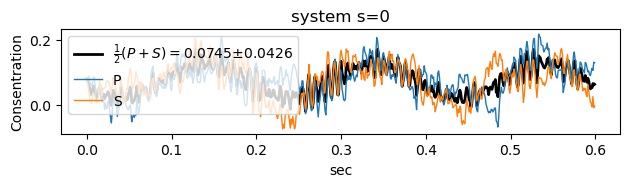

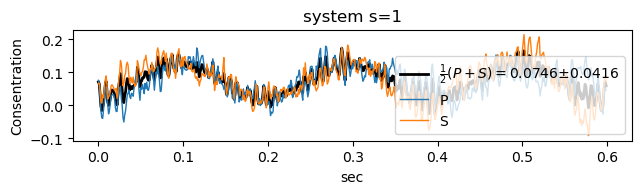

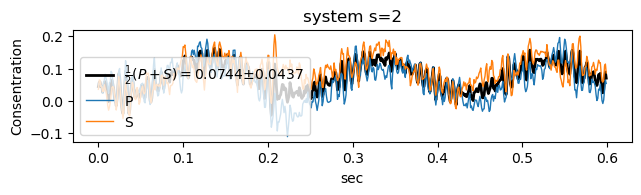

In [ ]:
observations_dyn = xs_dyn

nSec2Plot = sim_duration
titleStr = ''
plot(ts_dyn[:int(nSec2Plot/t_step)], observations_dyn[:,:3], xlabel='sec', ylabel='Consentration', title=titleStr)
observations_dyn = np.transpose(observations_dyn,(1,0,2))
observations_dyn = observations_dyn[:,:,1:3]
observations_dyn_tVec = ts_dyn[None,:,None].repeat(observations_dyn.shape[0], 0)
V_dyn = observations_dyn.mean(axis=2)[:,:,None]
w#saveCSV(observations, observations, 'ribosome_5.csv')

We first run the IRAS algorithm which fails to converge on the oscillating reference:

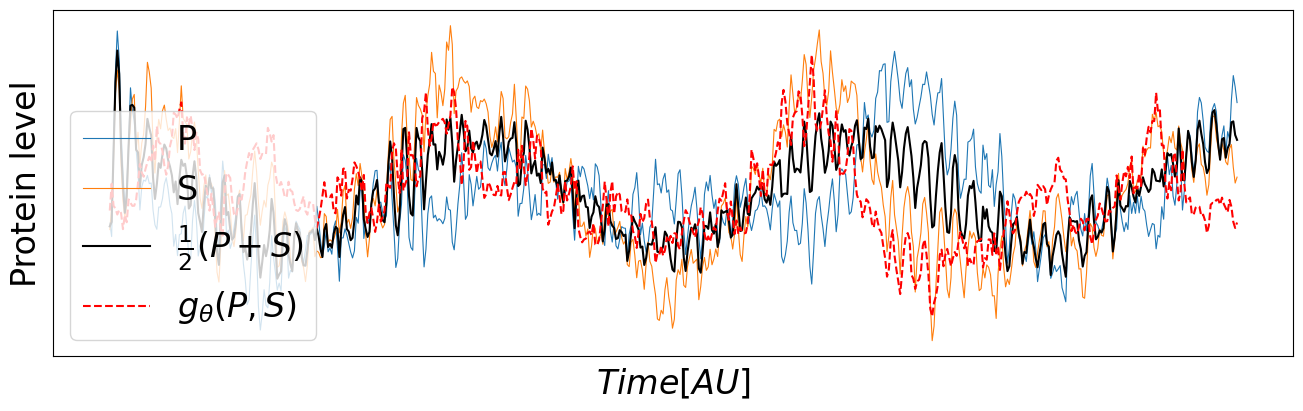

train. nativeIRAS SGD epoch 299: %Selected = 27, CR(zeta=1) = 0.761, CR = 1.0, ; Val_error = 2.46 db
Pearson correlation between learned combination g() and g^*() (mean,std) = 0.023, 0.129
Pearson correlation between the learned combination g() and the desired g^*() over 1 runs 0.023, 0.0


In [ ]:
IRAS_train_script(observations_dyn.copy(), observations_dyn_tVec.copy(), V_dyn.copy(), nativeIRAS=True)

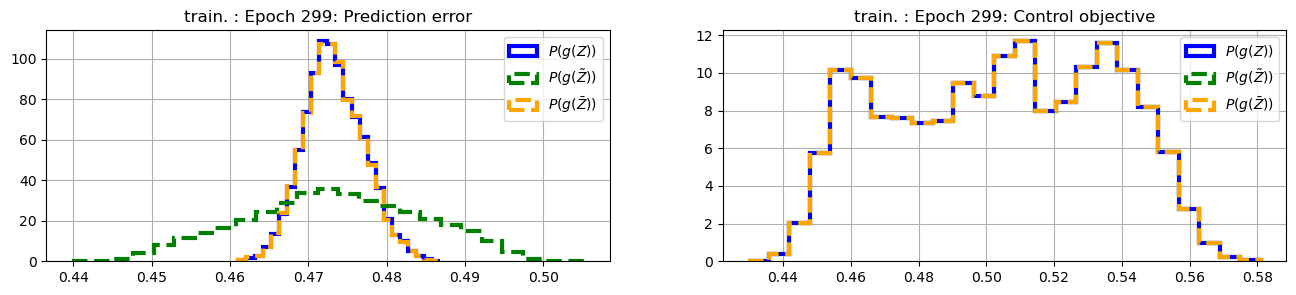

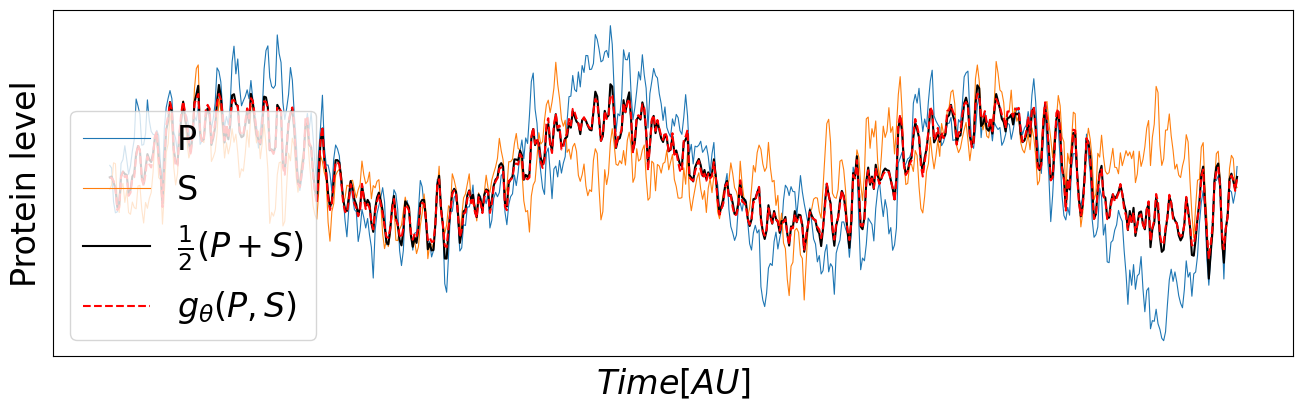

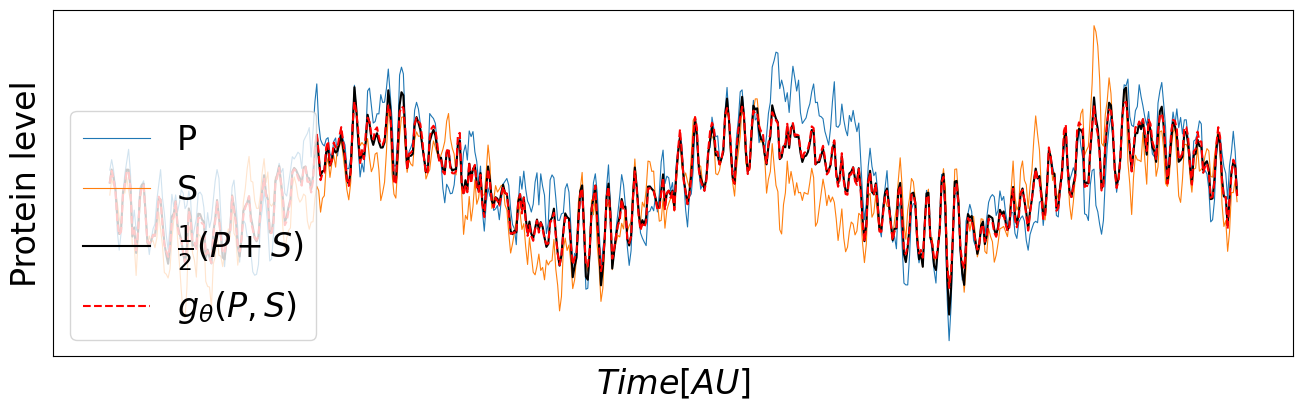

train. dtIRAS  Adam epoch 299: %Selected = 28, CR(zeta=1) = 0.344, CR = 0.999, predictionCorr (mean,std) = 0.882,0.007; Pred_error = -6.28 db; Val_error = -21.02 db
Pearson correlation between learned combination g() and g^*() (mean,std) = 0.996, 0.0
Pearson correlation between the learned combination g() and the desired g^*() over 1 runs 0.996, 0.0


In [ ]:
IRAS_train_script(observations_dyn.copy(), observations_dyn_tVec.copy(), V_dyn.copy(), nativeIRAS=False)